In [1]:
import hana_ml.dataframe as dataframe
import pandas as pd
import warnings

In [2]:
cc = dataframe.ConnectionContext(userkey = 'hana_ml_sl2044', encrypt = 'true', sslValidateCertificate = 'false')

In [3]:
# create a dataframe on the Hana table SALES_SC_LEVEL which is an extract of 2019 sales
df_2019_sales = cc.table('SALES_SC_LEVEL')

- Creating data description
- Counting missing values
- Judging high cardinality
- Finding skewed variables
- Calculating numeric distributions


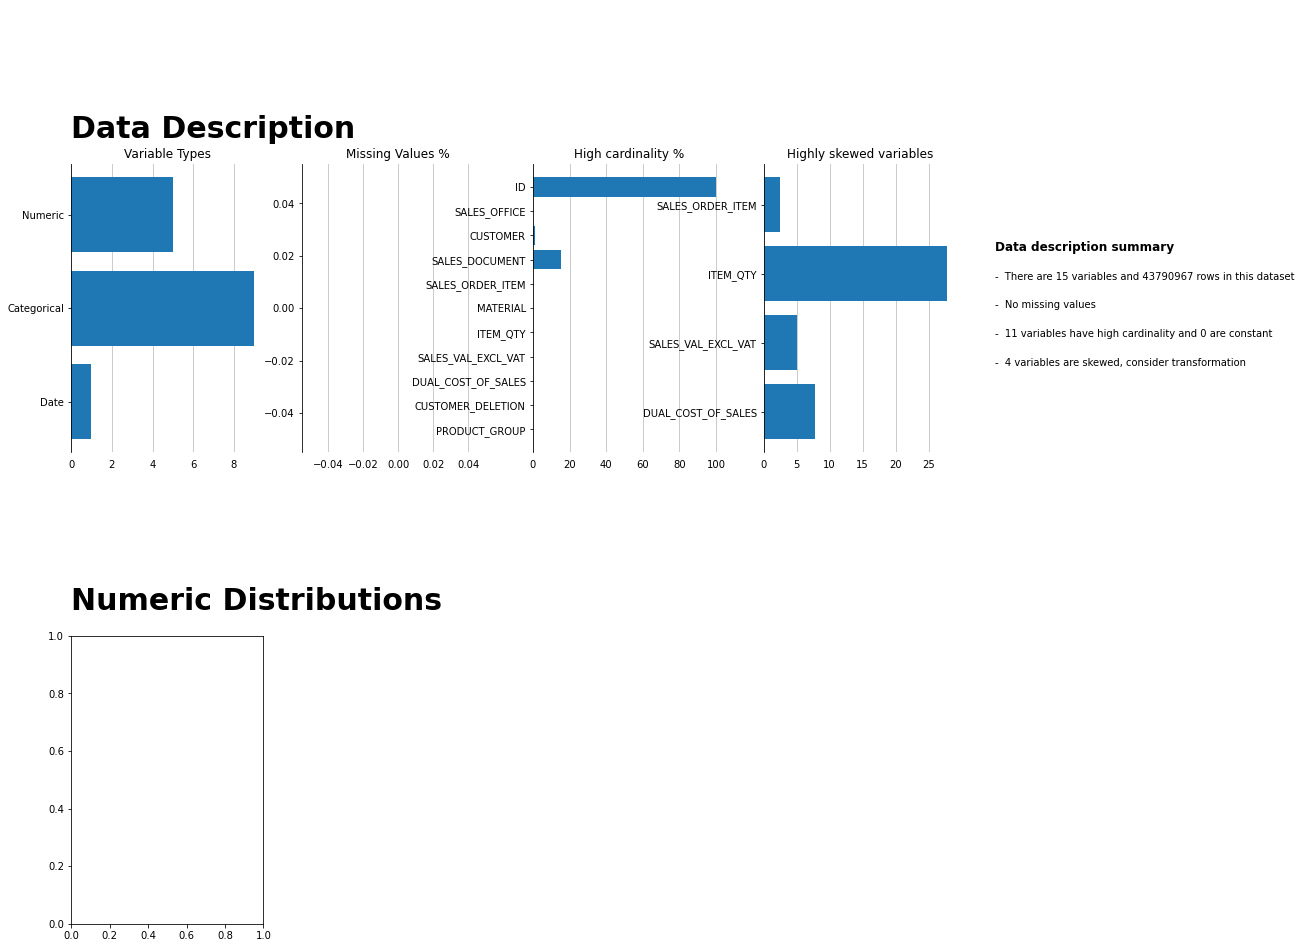

In [4]:
# Import Profiler class
from hana_ml.visualizers.eda import Profiler

# Create analysis and render plot
try:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        p = Profiler()
        fig = p.description(data=df_2019_sales, key="ID", missing_threshold=5, card_threshold=100)
        fig
except:
    pass

In [5]:
# build a dataset analysis report
#from hana_ml.visualizers.dataset_report import DatasetReportBuilder
#datasetReportBuilder = DatasetReportBuilder()
#df_report = df_2019_sales.select('ID', 'SALES_OFFICE', 'CUSTOMER', 'SALES_DOCUMENT', 'SALES_ORDER_ITEM', 'MATERIAL', 'ITEM_QTY', 'SALES_VAL_EXCL_VAT', 'DUAL_COST_OF_SALES', 'COMPONENT_FLAG', 'KITHEADER_FLAG', 'DOC_TYPE', 'CATEGORY', 'PRODUCT_GROUP')
#datasetReportBuilder.build(df_report, key='ID')
#datasetReportBuilder.generate_html_report('Sales Code level Sales Data Report.html')

In [4]:
# create a dictionary of material descriptions to help with a more meaningful
df_remote_desc = cc.table('MATERIAL_DESC')
desc_lookup = df_remote_desc.collect()[["MATERIAL","TXTMD"]].set_index('MATERIAL').T.to_dict('records')[0]

In [5]:
# Create the HANA dataframe using the SQL query to get a string list of items for each sales document (a basket) with the count of the number items in the basket where one of the items is a door
df_remote = cc.sql('select sales_document, STRING_AGG(material,\',\' order by material) as basket, count(*) as number_of_items \
                    from ( SELECT SALES_DOCUMENT, MATERIAL \
                        FROM SALES_SC_LEVEL \
                        WHERE COMPONENT_FLAG <> 1 \
                        AND SALES_DOCUMENT IN (\
                            SELECT DISTINCT SALES_DOCUMENT \
                            FROM SALES_SC_LEVEL \
                            WHERE COMPONENT_FLAG <> 1 \
                            AND CATEGORY = \'D\' ) ) \
                    group by sales_document ')

In [6]:
df_remote.head(3).collect()

,SALES_DOCUMENT,BASKET,NUMBER_OF_ITEMS
0,E470090843,"DIF1440,HNG0025,ITS0030,ITS0030,ITS0030",5
1,C290179386,"DCL0019,DCL0019,DFL1740,DFU0157,DFU0157,DFU017...",15
2,B610136997,"DFU0442,DFU0709,DIE6460,HNG0161,LAL0236,LAL024...",8


In [11]:
df_remote.collect().to_csv('df_sales_itema_2019.csv', index=False)

In [9]:
df_remote.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,NUMBER_OF_ITEMS,1074022,165,0,3.734187,4.372806,1.0,232.0,3.0,1.0,1.0,3.0,3.0,5.0,5.0
1,SALES_DOCUMENT,1074022,1074022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BASKET,1074022,510949,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
%matplotlib inline
from hana_ml.visualizers.eda import EDAVisualizer
import matplotlib.pyplot as plt

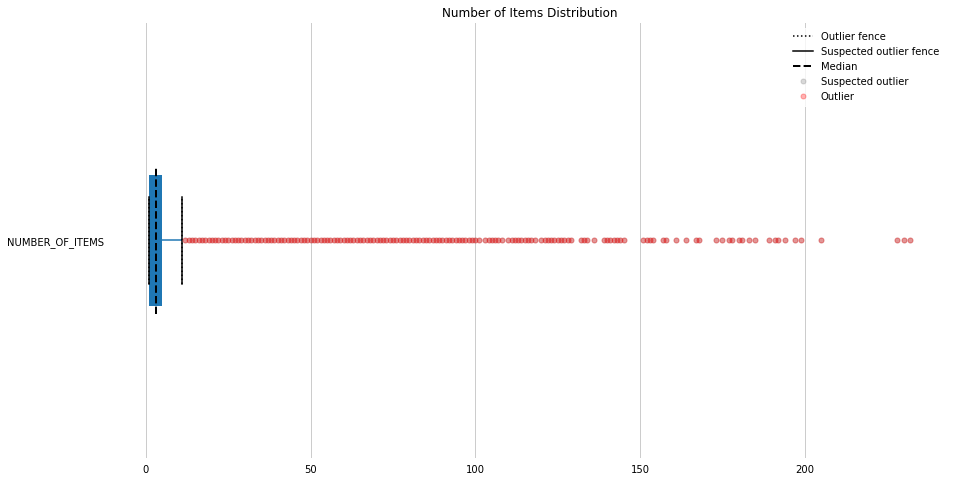

In [11]:
f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax, box_data = eda.box_plot(data=df_remote, column="NUMBER_OF_ITEMS", outliers=True, title="Number of Items Distribution")
plt.show()

In [12]:
df_freq = df_remote.agg(agg_list=[('count','NUMBER_OF_ITEMS','FREQUENCY')],group_by='NUMBER_OF_ITEMS')

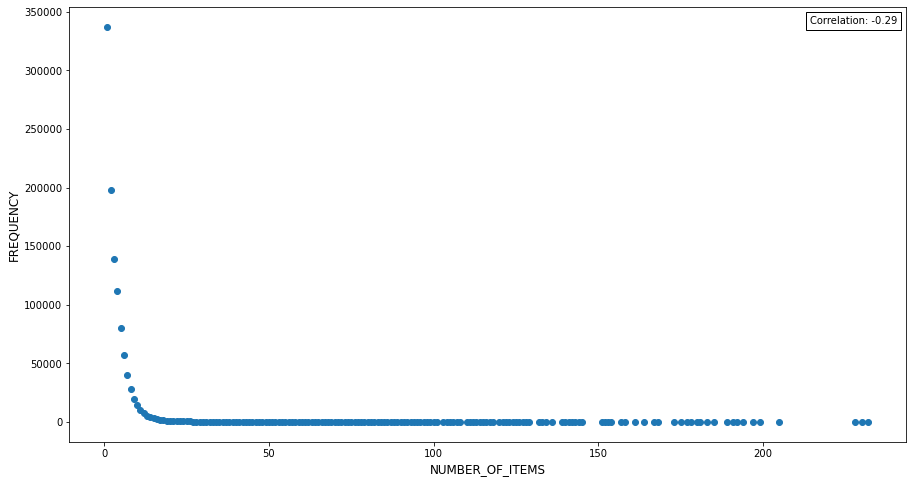

In [13]:
f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
eda.scatter_plot(data=df_freq, x="NUMBER_OF_ITEMS", y="FREQUENCY")
plt.show()

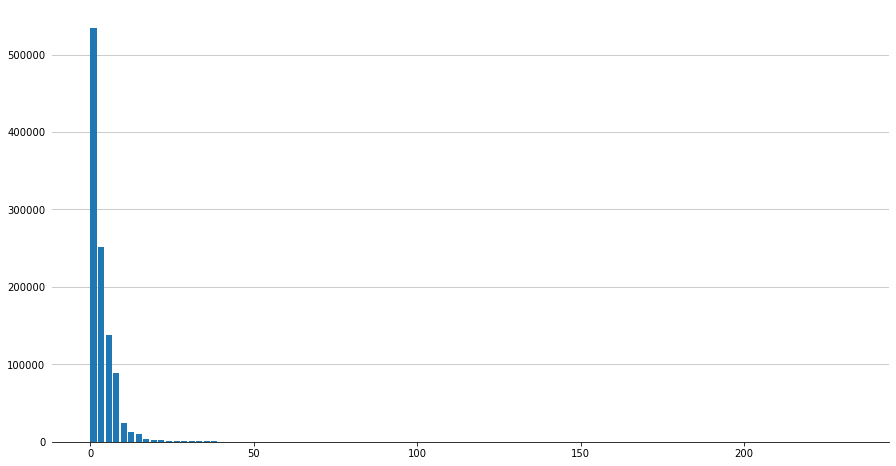

In [14]:
f = plt.figure(figsize=(15,8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
eda.distribution_plot(data=df_remote, column="NUMBER_OF_ITEMS", bins=100)
plt.show()

In [15]:
from itertools import combinations
from collections import Counter

In [16]:
df = df_remote.collect()

In [17]:
# find the most common combination of 3 (the median items in a basket) items in a basket
count = Counter()

for row in df['BASKET']:
    row_list = row.split(",")
    count.update(Counter(combinations(row_list,3)))

count.most_common(10)

[(('DIC0940', 'DIC0960', 'LAL0756'), 4907),
 (('DIC8340', 'DIC8360', 'LAL0758'), 4884),
 (('DFU0432', 'LAL0130', 'LAL0758'), 4361),
 (('DXE0001', 'DXF0160', 'LAL0230'), 4229),
 (('DXF0160', 'LAL0226', 'LAL0230'), 4047),
 (('DXF0160', 'LAL0230', 'LAL0505'), 3968),
 (('DXF0160', 'GIR0038', 'LAL0230'), 3935),
 (('DXF0160', 'LAL0230', 'SCF0009'), 3899),
 (('DXE0001', 'DXF0160', 'LAL0226'), 3849),
 (('DXE0001', 'DXF0160', 'LAL0505'), 3835)]

In [18]:
df_basket = pd.DataFrame.from_records(count.most_common(), columns=['item_list','count'])

In [19]:
df_basket[['item1','item2','item3']] = pd.DataFrame(df_basket['item_list'].tolist(), index=df_basket.index)

In [22]:
df_basket.sort_values(by=['count'], ascending=False).head(100000).to_csv('df_basket.csv', index=False)

In [23]:
# add sku descriptions to items to make it more readable
df_basket['ITEM1_DESC'] = df_basket['item1'].map(desc_lookup).fillna(df_basket['item1'])
df_basket['ITEM2_DESC'] = df_basket['item2'].map(desc_lookup).fillna(df_basket['item2'])
df_basket['ITEM3_DESC'] = df_basket['item3'].map(desc_lookup).fillna(df_basket['item3'])

In [24]:
# create a new dataframe of the result using sku descriptions
df_basket_desc = df_basket[['ITEM1_DESC','ITEM2_DESC','ITEM3_DESC','count']]

In [25]:
# show the result (ordered by lift) using SKU descriptions
df_basket_desc.sort_values(by=['count'], ascending=False).head(10)

,ITEM1_DESC,ITEM2_DESC,ITEM3_DESC,count
0,"Colonial 2'3"" Grained 6 Panel","Colonial 2'6"" Grained 6 Panel",Budget Chrome Latch Pack,4907
1,"Dordogne Smooth 2'3""","Dordogne Smooth 2'6""",Newington Sat/Pol Chr Rose Handle LAL Pk,4884
2,Round Polished/Satin Bathroom Turn,"EB/NP 3"" Bathroom Bolt (dual plate)",Newington Sat/Pol Chr Rose Handle LAL Pk,4361
3,Hardwood weather bar,"Dunsfold 2'6"" Flush External FD30","Euro/oval cyl deadlck case 3"" satin",4229
4,"Dunsfold 2'6"" Flush External FD30",Satin thumbturn euro cylinder,"Euro/oval cyl deadlck case 3"" satin",4047
5,"Dunsfold 2'6"" Flush External FD30","Euro/oval cyl deadlck case 3"" satin",Nightlatch yale 89 gry case brs cyl,3968
6,"Dunsfold 2'6"" Flush External FD30",933mm Aluminium Threshex,"Euro/oval cyl deadlck case 3"" satin",3935
7,"Dunsfold 2'6"" Flush External FD30","Euro/oval cyl deadlck case 3"" satin",Era chrome door viewer,3899
8,Hardwood weather bar,"Dunsfold 2'6"" Flush External FD30",Satin thumbturn euro cylinder,3849
9,Hardwood weather bar,"Dunsfold 2'6"" Flush External FD30",Nightlatch yale 89 gry case brs cyl,3835


In [26]:
df_basket_desc.sort_values(by=['count'], ascending=False).head(100000).to_csv('df_basket_desc.csv', index=False)